In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helper_methods import get_train_val, create_dataset, show_images

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torch.utils.data import TensorDataset, DataLoader

In [9]:
df_train, df_val = get_train_val(filepath='C:\\Users\\alexa\\Documents\\Deep Learning\\Project\\datasets\\annotations\\annotations\\trainval.txt', val_size=0.2)

# C:\\Users\\alexa\\Documents\\Deep Learning\\Project\\datasets\\images\\images\\

X_train, Y_train = create_dataset(df_train, base_path='C:\\Users\\alexa\\Documents\\Deep Learning\\Project\\datasets\\images\\images\\')
X_val, Y_val = create_dataset(df_val, base_path='C:\\Users\\alexa\\Documents\\Deep Learning\\Project\\datasets\\images\\images\\')

Y_train = Y_train.long()
Y_val = Y_val.long()

### Defome the base class for Image Classification

In [4]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):

        images, labels = batch 
        out = self(images)
        with torch.no_grad():
            loss = F.cross_entropy(out, labels)   
            acc = accuracy(out, labels)           
        
        return {'val_loss': loss.detach(), 'val_acc': acc}

In [5]:
class DogsCatsCnnModelResNet18(ImageClassificationBase):
    def __init__(self):
        
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [6]:
@torch.no_grad()
def evaluate(model: ImageClassificationBase, X_val, Y_val):

    model.eval()
    batch = [X_val, Y_val]
    outputs = model.validation_step(batch)
    
    return outputs

def fit(model: ImageClassificationBase, epochs, lr, X_train, Y_train, X_val, Y_val, batch_size=32, opt_func=torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(), lr)

    # Create TensorDataset and DataLoader for training data
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
                
        # Training Phase 
        model.train()
        train_losses = []
        for i, batch in enumerate(train_loader):
            print(f"  - Batch {i}/{int(len(X_train) / batch_size)}")
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, X_val, Y_val)
        print(f"Epoch {epoch}, result: {result}")
        history.append(result)
        
    return history

In [7]:
model_resnet_18 = DogsCatsCnnModelResNet18()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\alexa/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:09<00:00, 4.85MB/s]


#### Performance on validation set with initial set of params

In [10]:
print(evaluate(model_resnet_18, X_val, Y_val))

{'val_loss': tensor(0.7358), 'val_acc': tensor(0.3356)}


#### Try training for X epochs

In [11]:
num_epochs = 3
opt_func = torch.optim.Adam
batch_size = 256
lr = 0.001

In [12]:
history0 = fit(model_resnet_18, num_epochs, lr, X_train, Y_train, X_val, Y_val, batch_size, opt_func)

Epoch: 0
  - Batch 0/11
  - Batch 1/11
  - Batch 2/11
  - Batch 3/11
  - Batch 4/11
  - Batch 5/11
  - Batch 6/11
  - Batch 7/11
  - Batch 8/11
  - Batch 9/11
  - Batch 10/11
  - Batch 11/11
Epoch 0, result: {'val_loss': tensor(0.3577), 'val_acc': tensor(0.9552)}
Epoch: 1
  - Batch 0/11
  - Batch 1/11
  - Batch 2/11
  - Batch 3/11
  - Batch 4/11
  - Batch 5/11
  - Batch 6/11
  - Batch 7/11
  - Batch 8/11
  - Batch 9/11
  - Batch 10/11
  - Batch 11/11
Epoch 1, result: {'val_loss': tensor(0.4603), 'val_acc': tensor(0.8533)}
Epoch: 2
  - Batch 0/11
  - Batch 1/11
  - Batch 2/11
  - Batch 3/11
  - Batch 4/11
  - Batch 5/11
  - Batch 6/11
  - Batch 7/11
  - Batch 8/11
  - Batch 9/11
  - Batch 10/11
  - Batch 11/11
Epoch 2, result: {'val_loss': tensor(0.4425), 'val_acc': tensor(0.8614)}


In [15]:
history0

[{'val_loss': tensor(0.3577), 'val_acc': tensor(0.9552)},
 {'val_loss': tensor(0.4603), 'val_acc': tensor(0.8533)},
 {'val_loss': tensor(0.4425), 'val_acc': tensor(0.8614)}]

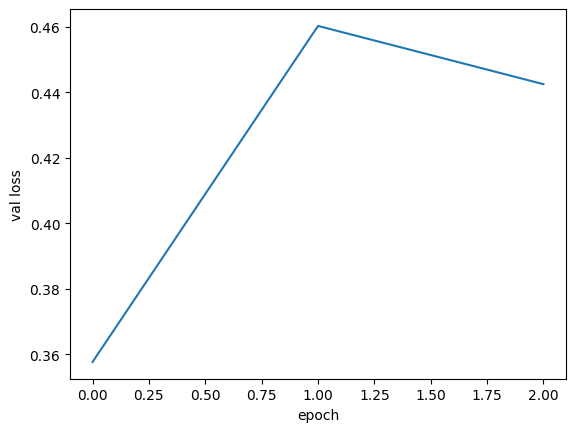

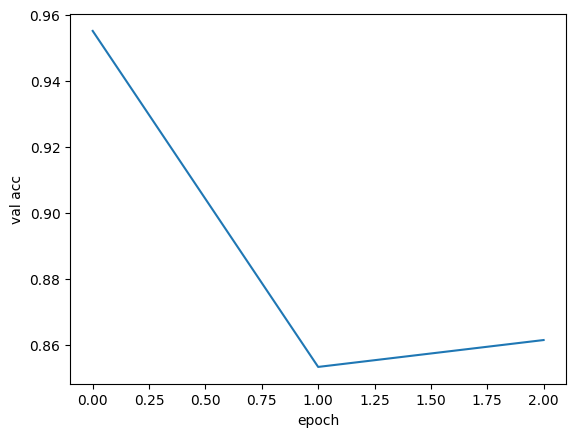

In [16]:
def plot_results(history):
    val_loss = [d['val_loss'] for d in history]
    val_acc = [d['val_acc'] for d in history]
    plt.plot(val_loss)
    plt.xlabel('epoch')
    plt.ylabel('val loss')
    plt.show()
    plt.plot(val_acc)
    plt.xlabel('epoch')
    plt.ylabel('val acc')
    plt.show()

plot_results(history0)